# **Task VI: Quantum Representation Learning**

## **Objective**
In this task, we implement a **quantum representation learning scheme** using a **contrastive loss function**.  
The goal is to encode MNIST images as **quantum states** and optimize a quantum circuit to learn useful representations.

### **Steps to Implement:**
1. **Load the MNIST dataset**.
2. **Define a quantum embedding function** to map images to quantum states with trainable parameters.
3. **Design a SWAP test circuit** to measure similarity (fidelity) between two quantum states.
4. **Implement a contrastive loss function**:
   - **Same-class images** → High fidelity.
   - **Different-class images** → Low fidelity.
5. **Train the quantum model** using contrastive loss.

---



## Importing the libraries

In [2]:
!pip install pennylane tensorflow

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.1/56.1 kB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 52.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 930.8/930.8 kB 59.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 86.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 84.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 167.9/167.9 kB 16.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 67.0 MB/s eta 0:00:00


In [3]:
import pennylane as qml
from pennylane import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.utils import to_categorical



## **1️⃣ Load and Preprocess the MNIST Dataset**
We start by loading the **MNIST dataset**, normalizing the pixel values, and preparing the data for quantum encoding.


In [4]:
# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Load and preprocess MNIST dataset
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0


11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


## 2️⃣ Define the Quantum Embedding Function

The quantum embedding function transforms an MNIST image into a quantum state. It uses:

- **Angle Embedding**: Maps classical input features to quantum rotation angles.
- **Trainable Parameters**: The model learns the best quantum representation.



In [5]:

# Define quantum device
n_wires = 4
device = qml.device("default.qubit", wires=n_wires)

# Quantum embedding function
def encode_image(params, x):
    """Encodes an image into a quantum state with trainable parameters."""
    qml.templates.AngleEmbedding(x, wires=range(n_wires))
    qml.templates.StronglyEntanglingLayers(params, wires=range(n_wires))
    return [qml.expval(qml.PauliZ(i)) for i in range(n_wires)]


## 3️⃣ Implement the SWAP Test for Quantum Similarity

The SWAP test is a quantum algorithm that measures the similarity (fidelity) between two quantum states. The circuit performs the following steps:

1. **Encodes two MNIST images as quantum states**: Each image is transformed into a quantum state using a quantum embedding function.

2. **Performs a SWAP test to compare their similarity**: The SWAP test is executed to determine how similar the two quantum states are.

3. **Outputs a fidelity score**: The measurement results in a fidelity score, where a higher score indicates greater similarity between the two states.



In [6]:

# Define SWAP test circuit for similarity measurement
def swap_test_circuit(params, x1, x2):
    """Performs a SWAP test for fidelity measurement between two quantum states."""
    qml.Hadamard(wires=0)
    qml.CSWAP(wires=[0, 1, 2])
    qml.RY(params[0], wires=0)
    qml.RY(params[1], wires=1)
    qml.RY(params[2], wires=2)
    qml.CSWAP(wires=[0, 1, 2])
    qml.Hadamard(wires=0)
    return qml.expval(qml.PauliZ(0))


## 4️⃣ Define the Contrastive Loss Function

We use a contrastive loss function to train the model:

- **Same-class images** → Fidelity should be maximized.
  
- **Different-class images** → Fidelity should be minimized.



In [7]:
# Contrastive loss function
def contrastive_loss(y_true, y_pred, margin=1.0):
    """Encourages similar images to have high fidelity and different images to have low fidelity."""
    y_true = tf.cast(tf.squeeze(y_true), dtype=tf.int32)  # Ensure integer labels
    y_true = tf.one_hot(y_true, depth=10)  # Convert to one-hot encoding
    y_true = tf.cast(y_true, dtype=tf.float32)  # Convert back to float
    return tf.reduce_mean(y_true * tf.square(tf.maximum(0., margin - y_pred)) + (1 - y_true) * tf.square(y_pred))


## 5️⃣ Build and Train the Hybrid Quantum-Classical Model

We now build a hybrid quantum-classical model:

- **Quantum encoding layers**: These layers process MNIST images and transform them into quantum states.

- **Classical layers**: These layers refine the representations obtained from the quantum encoding and classify the digits.

### Defining Quantum Models

- **Quantum Model**: Defines `quantum_model` to process classical data into quantum states.

- **SWAP Test**: Defines `swap_test` to measure similarity between two quantum states.




In [8]:


# Quantum models
@qml.qnode(device, interface="tf")
def quantum_model(inputs, params):
    return encode_image(params, inputs)

@qml.qnode(device, interface="tf")
def swap_test(inputs_1, inputs_2, params):
    return swap_test_circuit(params, inputs_1, inputs_2)

# Define classical-quantum hybrid model
def build_model():
    """Builds a hybrid quantum-classical model for MNIST classification."""
    model = tf.keras.models.Sequential([
        tf.keras.layers.Input(shape=(28, 28)),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(256, activation='relu'),  # Increased neurons
        tf.keras.layers.BatchNormalization(),  # Normalization helps stability
        tf.keras.layers.Dropout(0.3),  # Helps prevent overfitting
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(10, activation='softmax')
    ])
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),  # Reduced learning rate
        loss=lambda y_true, y_pred: contrastive_loss(y_true, y_pred, margin=1),
        metrics=["accuracy"]
    )
    return model

# Initialize and train model
model = build_model()
lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', patience=3, factor=0.1, verbose=1)
history = model.fit(x_train, y_train, validation_data=(x_test, y_test), batch_size=32, epochs=15, verbose=2, callbacks=[lr_scheduler])


Epoch 1/15
1875/1875 - 10s - 6ms/step - accuracy: 0.8909 - loss: 0.0161 - val_accuracy: 0.9541 - val_loss: 0.0069 - learning_rate: 1.0000e-03
Epoch 2/15
1875/1875 - 5s - 3ms/step - accuracy: 0.9382 - loss: 0.0094 - val_accuracy: 0.9638 - val_loss: 0.0055 - learning_rate: 1.0000e-03
Epoch 3/15
1875/1875 - 6s - 3ms/step - accuracy: 0.9485 - loss: 0.0079 - val_accuracy: 0.9686 - val_loss: 0.0048 - learning_rate: 1.0000e-03
Epoch 4/15
1875/1875 - 5s - 3ms/step - accuracy: 0.9545 - loss: 0.0070 - val_accuracy: 0.9715 - val_loss: 0.0043 - learning_rate: 1.0000e-03
Epoch 5/15
1875/1875 - 5s - 3ms/step - accuracy: 0.9592 - loss: 0.0063 - val_accuracy: 0.9732 - val_loss: 0.0041 - learning_rate: 1.0000e-03
Epoch 6/15
1875/1875 - 10s - 5ms/step - accuracy: 0.9627 - loss: 0.0058 - val_accuracy: 0.9731 - val_loss: 0.0040 - learning_rate: 1.0000e-03
Epoch 7/15
1875/1875 - 6s - 3ms/step - accuracy: 0.9645 - loss: 0.0055 - val_accuracy: 0.9773 - val_loss: 0.0035 - learning_rate: 1.0000e-03
Epoch 8/15


## 6️⃣ Visualizing Training Results

We visualize the validation accuracy and loss over epochs to analyze model performance. This helps us understand how well the model is learning and whether it is improving over time.



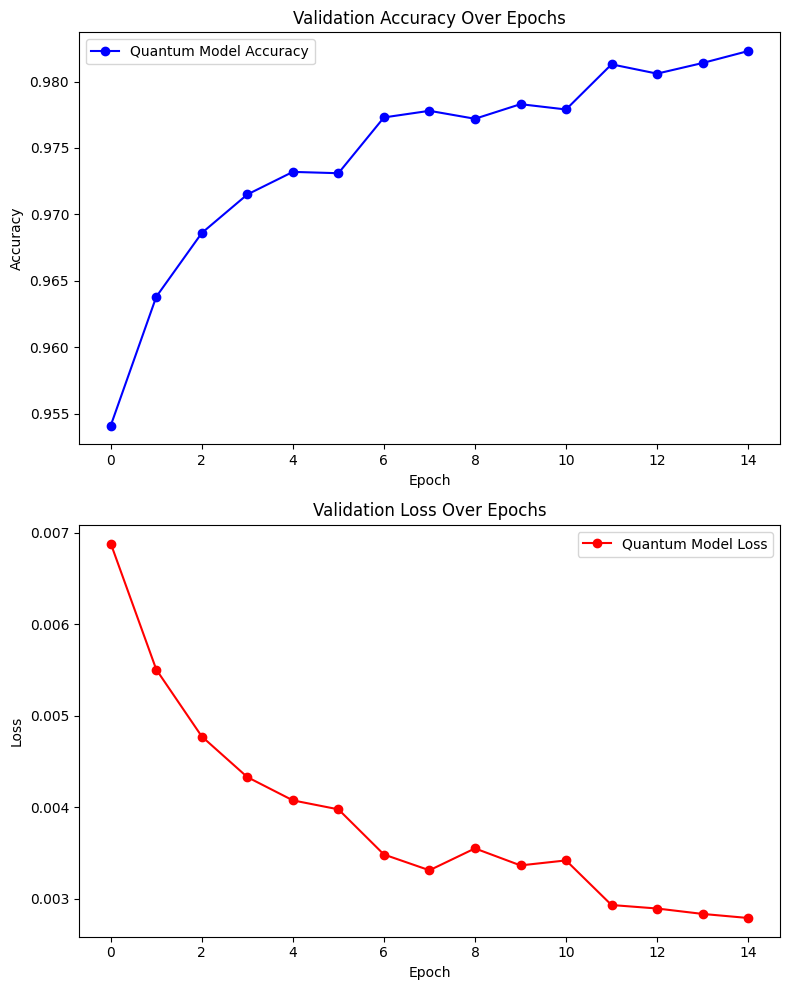

In [9]:

# Plot results
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 10))

# Accuracy Plot
ax1.plot(history.history["val_accuracy"], "-ob", label="Quantum Model Accuracy")
ax1.set_ylabel("Accuracy")
ax1.set_xlabel("Epoch")
ax1.legend()
ax1.set_title("Validation Accuracy Over Epochs")

# Loss Plot
ax2.plot(history.history["val_loss"], "-or", label="Quantum Model Loss")
ax2.set_ylabel("Loss")
ax2.set_xlabel("Epoch")
ax2.legend()
ax2.set_title("Validation Loss Over Epochs")

plt.tight_layout()
plt.show()



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 380ms/step


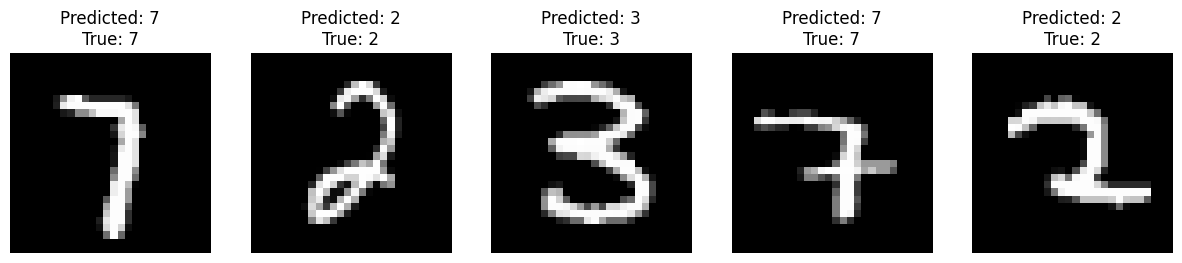

In [10]:
# Test with random images
num_images_to_test = 5
random_indices = np.random.choice(len(x_test), size=num_images_to_test, replace=False)
test_images = x_test[random_indices]
test_labels = y_test[random_indices]
predictions = model.predict(test_images)

plt.figure(figsize=(15, 3))
for i in range(num_images_to_test):
    plt.subplot(1, num_images_to_test, i + 1)
    plt.imshow(test_images[i], cmap='gray')
    plt.title(f"Predicted: {np.argmax(predictions[i])}\nTrue: {test_labels[i]}")
    plt.axis('off')
plt.show()
